# Read data from HDFS

In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession :D
spark = (SparkSession.builder.appName("FANNG-Stock-Project").getOrCreate())

# Read a CSV file with header and infer schema
amazon_df = spark.read.csv("hdfs://namenode:9000/data/raw/Amazon.csv", header=True, inferSchema=True)
facebook_df = spark.read.csv("hdfs://namenode:9000/data/raw/Facebook.csv", header=True, inferSchema=True)
apple_df = spark.read.csv("hdfs://namenode:9000/data/raw/Apple.csv", header=True, inferSchema=True)
netflix_df = spark.read.csv("hdfs://namenode:9000/data/raw/Netflix.csv", header=True, inferSchema=True)
google_df = spark.read.csv("hdfs://namenode:9000/data/raw/Google.csv", header=True, inferSchema=True)

# Show the DataFrame 
amazon_df.show()

# Print the schema 
amazon_df.printSchema()


+----------+--------+--------+--------+--------+---------+--------+
|      Date|    Open|    High|     Low|   Close|Adj Close|  Volume|
+----------+--------+--------+--------+--------+---------+--------+
|1997-05-15|  2.4375|     2.5|1.927083|1.958333| 1.958333|72156000|
|1997-05-16| 1.96875|1.979167|1.708333|1.729167| 1.729167|14700000|
|1997-05-19|1.760417|1.770833|   1.625|1.708333| 1.708333| 6106800|
|1997-05-20|1.729167|    1.75|1.635417|1.635417| 1.635417| 5467200|
|1997-05-21|1.635417|1.645833|   1.375|1.427083| 1.427083|18853200|
|1997-05-22|  1.4375|1.447917|  1.3125|1.395833| 1.395833|11776800|
|1997-05-23| 1.40625|1.520833|1.333333|     1.5|      1.5|15937200|
|1997-05-27|1.510417|1.645833|1.458333|1.583333| 1.583333| 8697600|
|1997-05-28|   1.625|1.635417| 1.53125| 1.53125|  1.53125| 4574400|
|1997-05-29|1.541667|1.541667|1.479167|1.505208| 1.505208| 3472800|
|1997-05-30|     1.5|1.510417|1.479167|     1.5|      1.5| 2594400|
|1997-06-02|1.510417| 1.53125|     1.5|1.510417|

# Data exploration and preprocessing

In [25]:
from pyspark.sql import functions as F

# Add label each DataFrame
amazon_df  = amazon_df.withColumn("ticker", F.lit("AMZN"))
facebook_df = facebook_df.withColumn("ticker", F.lit("META"))
apple_df   = apple_df.withColumn("ticker", F.lit("AAPL"))
netflix_df = netflix_df.withColumn("ticker", F.lit("NFLX"))
google_df  = google_df.withColumn("ticker", F.lit("GOOGL"))

# combine the data frame
prices_raw = (amazon_df.unionByName(facebook_df)
                      .unionByName(apple_df)
                      .unionByName(netflix_df)
                      .unionByName(google_df))

prices_raw.show(2)
prices_raw.printSchema()

# Filter the duplicate 
prices = (prices_raw
         .dropna(subset=["Date","Adj Close"])
         .dropDuplicates(["ticker","Date"])
         .filter(F.col("Volume") >= 0))

prices.show(10, truncate=False)

+----------+-------+--------+--------+--------+---------+--------+------+
|      Date|   Open|    High|     Low|   Close|Adj Close|  Volume|ticker|
+----------+-------+--------+--------+--------+---------+--------+------+
|1997-05-15| 2.4375|     2.5|1.927083|1.958333| 1.958333|72156000|  AMZN|
|1997-05-16|1.96875|1.979167|1.708333|1.729167| 1.729167|14700000|  AMZN|
+----------+-------+--------+--------+--------+---------+--------+------+
only showing top 2 rows

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- ticker: string (nullable = false)

+----------+--------+--------+--------+--------+---------+---------+------+
|Date      |Open    |High    |Low     |Close   |Adj Close|Volume   |ticker|
+----------+--------+--------+--------+--------+---------+---------+------+

In [3]:
# Table of the basic coverage per ticker
coverage = (prices.groupBy("ticker").agg(
    F.count("*").alias("rows"),
    F.min("Date").alias("start"),
    F.max("Date").alias("end")
).orderBy("ticker"))

coverage.show(truncate=False)

+------+----+----------+----------+
|ticker|rows|start     |end       |
+------+----+----------+----------+
|AAPL  |9980|1980-12-12|2020-09-01|
|AMZN  |5852|1997-05-15|2020-08-14|
|GOOGL |4041|2004-08-19|2020-09-04|
|META  |2076|2012-05-18|2020-08-18|
|NFLX  |4581|2002-05-23|2020-08-03|
+------+----+----------+----------+



# CRUD operations

In [52]:
# Treat 'Volume == 0' as missing and set to NULL so stats ignore it.
prices_updated = prices.withColumn("Volume", F.when(F.col("Volume")==0, F.lit(None)).otherwise(F.col("Volume")))

# Drop very old rows to simulate a maintenance delete (e.g., pre-2010).
prices_updated = prices_updated.filter(F.col("Date") >= F.to_date(F.lit("2013-01-01")))

prices_updated.show()

# Write and uploaded a SINGLE cdv file as the updated csv
prices_updated.coalesce(1).write.csv("hdfs://namenode:9000/data/updated", 
                                     header=True, mode="overwrite")
prices_updated.coalesce(1).write.csv("updated", 
                                     header=True, mode="overwrite")

+----------+-----------+-----------+-----------+-----------+-----------+---------+------+
|      Date|       Open|       High|        Low|      Close|  Adj Close|   Volume|ticker|
+----------+-----------+-----------+-----------+-----------+-----------+---------+------+
|2013-04-24|  14.055000|  14.830358|  14.017858|  14.480714|  12.698048|969651200|  AAPL|
|2014-01-23|  19.640715|  19.875000|  19.457500|  19.863571|  17.752350|403239200|  AAPL|
|2014-01-31|  17.684999|  17.911785|  17.626785|  17.878571|  15.978329|464797200|  AAPL|
|2014-11-18|  28.485001|  28.922501|  28.472500|  28.867500|  26.342228|176896000|  AAPL|
|2014-12-16|  26.592501|  27.540001|  26.565001|  26.687500|  24.352928|243162800|  AAPL|
|2015-02-26|  32.197498|  32.717499|  31.652500|  32.605000|  29.870203|365150000|  AAPL|
|2016-09-20|  28.262501|  28.530001|  28.127501|  28.392500|  26.798903|138057200|  AAPL|
|2019-04-15|  49.645000|  49.962502|  49.502499|  49.807499|  48.943016| 70146400|  AAPL|
|2013-08-0

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_per_ticker(df, x, y, title, ylabel, fname_prefix):
    for t in sorted(df['ticker'].unique()):
        d = df[df['ticker'] == t].sort_values(x)
        plt.figure(figsize=(10,4))
        plt.plot(d[x], d[y])
        plt.title(f"{title} — {t}")
        plt.xlabel(x)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

# Daily Return Comparsion
Show and compute the daily return 
by using (current adj close / previous day adj close) - 1

+------+----------+----------+---------+
|ticker| prev_date| next_date| adj_prev|
+------+----------+----------+---------+
|  AAPL|2013-01-02|2013-01-03|17.094694|
|  AAPL|2013-01-03|2013-01-04| 16.87892|
|  AAPL|2013-01-04|2013-01-07|16.408764|
|  AAPL|2013-01-07|2013-01-08|16.312239|
|  AAPL|2013-01-08|2013-01-09| 16.35615|
|  AAPL|2013-01-09|2013-01-10|16.100521|
|  AAPL|2013-01-10|2013-01-11|  16.3001|
|  AAPL|2013-01-11|2013-01-14|16.200155|
|  AAPL|2013-01-14|2013-01-15|15.622575|
|  AAPL|2013-01-15|2013-01-16|15.129693|
|  AAPL|2013-01-16|2013-01-17|15.757706|
|  AAPL|2013-01-17|2013-01-18|15.651527|
|  AAPL|2013-01-18|2013-01-22|15.568091|
|  AAPL|2013-01-22|2013-01-23|15.716609|
|  AAPL|2013-01-23|2013-01-24|16.004307|
|  AAPL|2013-01-24|2013-01-25| 14.02685|
|  AAPL|2013-01-25|2013-01-28|13.696181|
|  AAPL|2013-01-28|2013-01-29|14.005986|
|  AAPL|2013-01-29|2013-01-30|14.268773|
|  AAPL|2013-01-30|2013-01-31|14.223937|
+------+----------+----------+---------+
only showing top

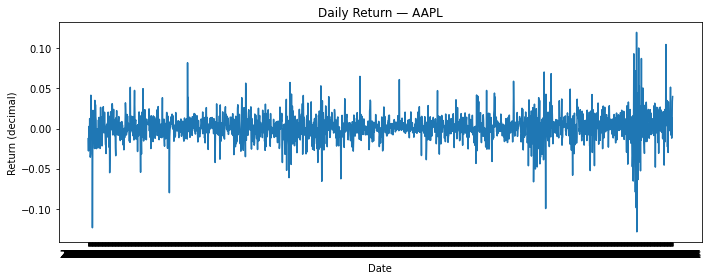

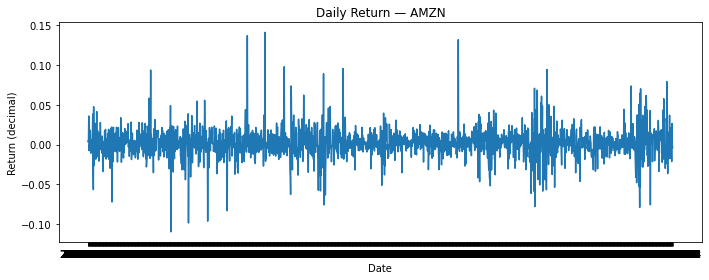

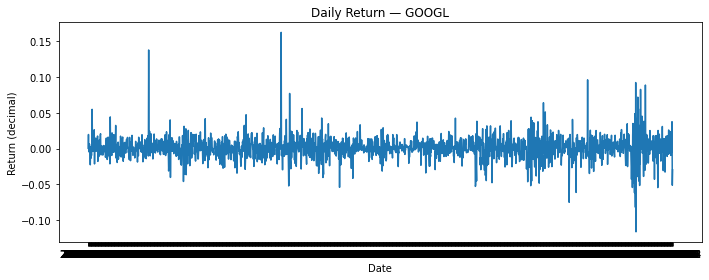

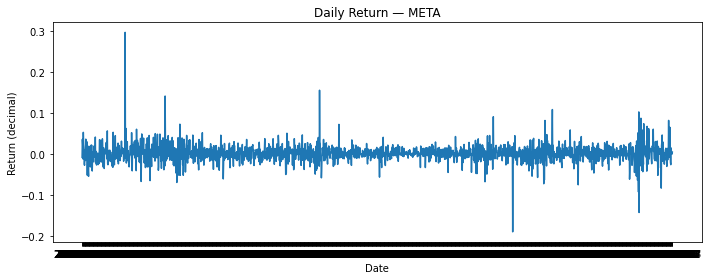

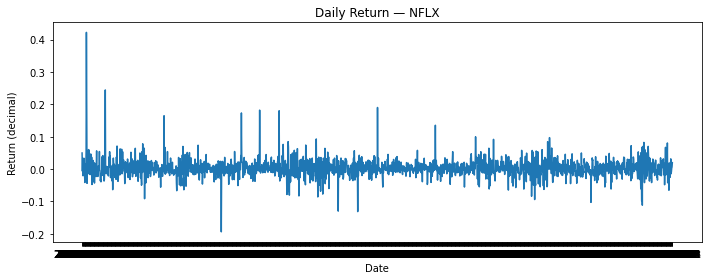

In [40]:
faang = (spark.read.csv("hdfs://namenode:9000/data/updated/*.csv",
                        header=True, inferSchema=True))
faang.createOrReplaceTempView("prices")

# Day Pair with Next Day or Next trade date session
spark.sql("""
CREATE OR REPLACE TEMP VIEW prev_day AS
SELECT
  ticker,
  Date AS prev_date,
  LEAD(Date) OVER (PARTITION BY ticker ORDER BY Date) AS next_date,
  `Adj Close` AS adj_prev
FROM prices
""")

# Check if correct
spark.sql("""
SELECT * FROM prev_day
""").show()

# Daily returns by JOIN (today vs yesterday)
spark.sql("""
CREATE OR REPLACE TEMP VIEW daily_returns AS
SELECT
  p.Date,
  p.ticker,
  p.`Adj Close` AS adj_close,
  d.adj_prev,
  (p.`Adj Close` / d.adj_prev - 1.0) AS daily_return
FROM prices p
JOIN prev_day d
  ON p.ticker = d.ticker
 AND p.Date = d.next_date
""")

result = spark.sql("""
SELECT * FROM daily_returns
ORDER BY ticker, Date
""")

result.show()

# Plot the diagram
df_daily = result.toPandas()
plot_per_ticker(
    df=df_daily,
    x="Date",
    y="daily_return",
    title="Daily Return",
    ylabel="Return (decimal)",
    fname_prefix="daily_return"
)

# Weekly Return Comparsion¶
Show and compute the weekly return 
by using (current week adj close / previous week adj close) - 1
REF: DATE_TRUNC https://www.codecademy.com/resources/docs/sql/dates/date-trunc

+------+-------------------+-----------+
|ticker|         week_start|   adj_last|
+------+-------------------+-----------+
|  AMZN|2015-02-02 00:00:00| 374.279999|
|  AMZN|2018-06-04 00:00:00| 1683.98999|
| GOOGL|2020-06-08 00:00:00|1412.920044|
|  META|2016-02-08 00:00:00| 102.010002|
|  META|2019-12-16 00:00:00| 206.300003|
|  NFLX|2014-09-15 00:00:00|  65.360001|
|  AAPL|2018-12-17 00:00:00|  36.870335|
|  AAPL|2019-12-02 00:00:00|  67.213799|
|  AMZN|2014-01-27 00:00:00| 358.690002|
|  AMZN|2014-12-01 00:00:00| 312.630005|
| GOOGL|2015-08-24 00:00:00| 659.690002|
| GOOGL|2017-07-24 00:00:00| 958.330017|
| GOOGL|2017-12-18 00:00:00|1068.859985|
| GOOGL|2018-04-16 00:00:00|1077.319946|
| GOOGL|2019-08-05 00:00:00|1188.900024|
|  META|2016-10-17 00:00:00| 132.070007|
|  META|2019-09-02 00:00:00| 187.490005|
|  NFLX|2018-05-28 00:00:00| 359.929993|
|  NFLX|2018-07-30 00:00:00| 343.089996|
|  NFLX|2019-05-13 00:00:00| 354.450012|
+------+-------------------+-----------+
only showing top

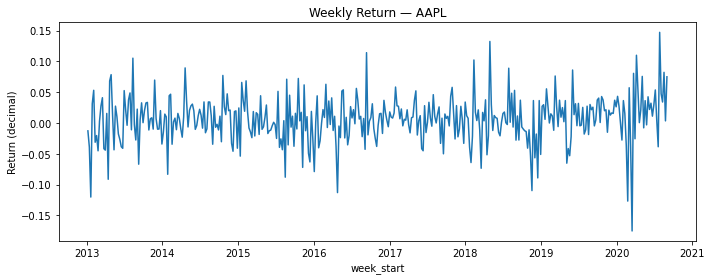

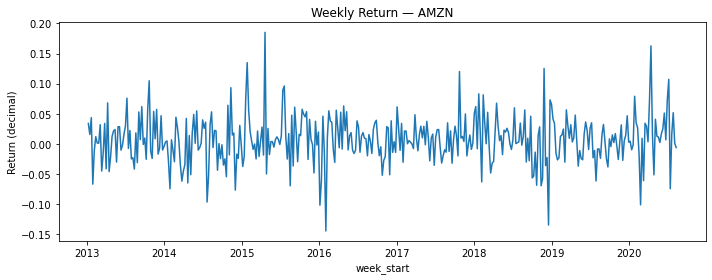

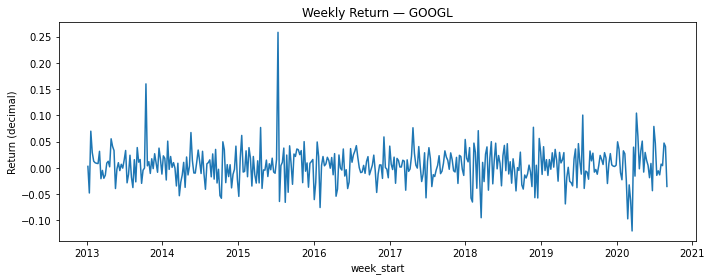

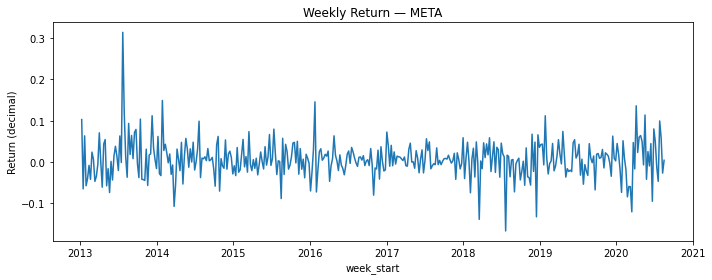

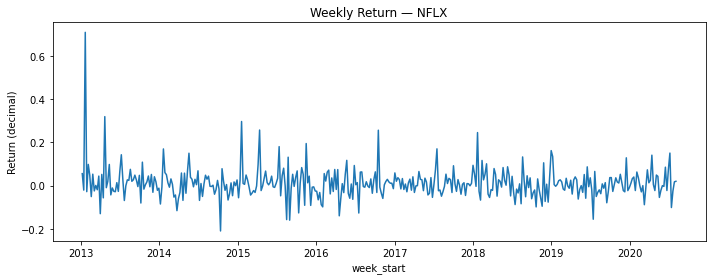

In [49]:
faang = (spark.read.csv("hdfs://namenode:9000/data/updated/*.csv",
                        header=True, inferSchema=True))

faang.createOrReplaceTempView("prices")

# week Close
spark.sql("""
CREATE OR REPLACE TEMP VIEW weekly_last AS
SELECT ticker, DATE_TRUNC('week', Date) AS week_start, `Adj Close`,
  ROW_NUMBER() OVER (PARTITION BY ticker, 
  DATE_TRUNC('week', Date) ORDER BY Date DESC) AS rn
FROM prices
""")

# RN = 1, mean the last trading day of that week
spark.sql("""
CREATE OR REPLACE TEMP VIEW weekly_close AS
SELECT ticker, week_start, `Adj Close` AS adj_last
FROM weekly_last
WHERE rn = 1
""")

# Check
spark.sql("""
SELECT * FROM weekly_close 
""").show()

# Weekly returns by JOIN (current week vs previous week)
spark.sql("""
CREATE OR REPLACE TEMP VIEW weekly_returns AS
SELECT
  a.ticker,
  a.week_start,
  a.adj_last AS adj_close_week,
  b.adj_last AS adj_close_prev_week,
  (a.adj_last / b.adj_last - 1.0) AS weekly_return
FROM weekly_close a
JOIN weekly_close b
  ON a.ticker = b.ticker
 AND b.week_start = DATE_SUB(a.week_start, 7)
""")

result = spark.sql("""
SELECT ticker, week_start, weekly_return
FROM weekly_returns
ORDER BY ticker, week_start
""")

result.show(10)

# Plot the diagram
df_weekly = result.toPandas()
plot_per_ticker(
    df=df_weekly,
    x="week_start",
    y="weekly_return",
    title="Weekly Return",
    ylabel="Return (decimal)",
    fname_prefix="weekly_return"
)


# Cumulative (Long-Term) Return Comparsion¶

+------+----------+--------------------+
|ticker|      Date|   cumulative_return|
+------+----------+--------------------+
|  AAPL|2013-01-03|-0.01262227917036...|
|  AAPL|2013-01-04| -0.0401253160776085|
|  AAPL|2013-01-07|-0.04577180498229...|
|  AAPL|2013-01-08|-0.04320311319992043|
|  AAPL|2013-01-09|-0.05815681754818...|
|  AAPL|2013-01-10|-0.04648190836291055|
|  AAPL|2013-01-11|-0.05232845934533836|
|  AAPL|2013-01-14| -0.0861155514102796|
|  AAPL|2013-01-15|-0.11494800667388361|
|  AAPL|2013-01-16|-0.07821070093445359|
+------+----------+--------------------+
only showing top 10 rows



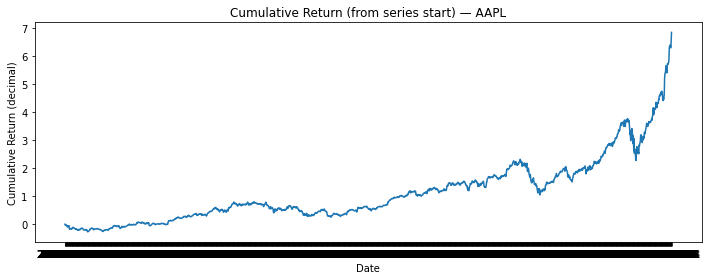

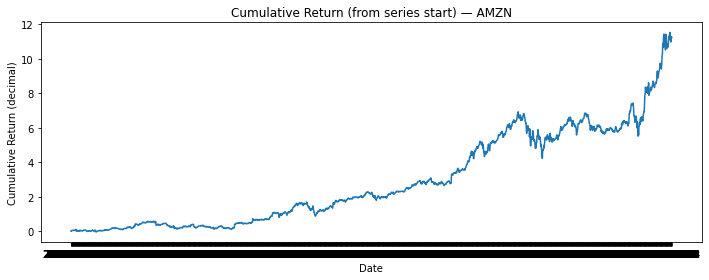

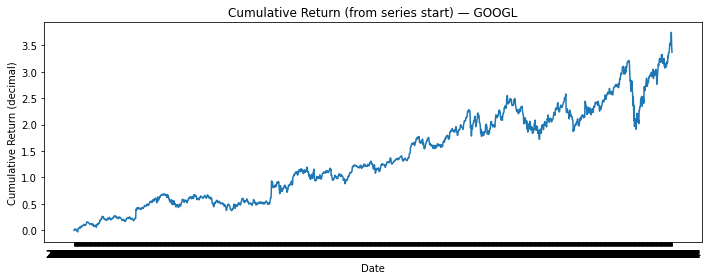

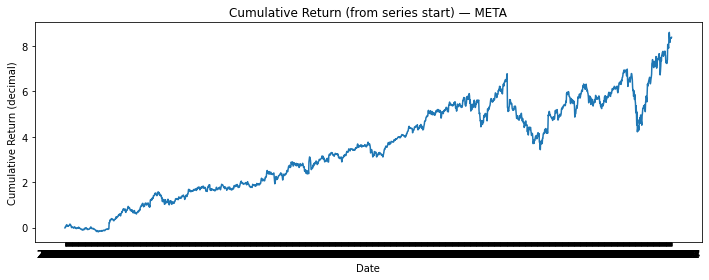

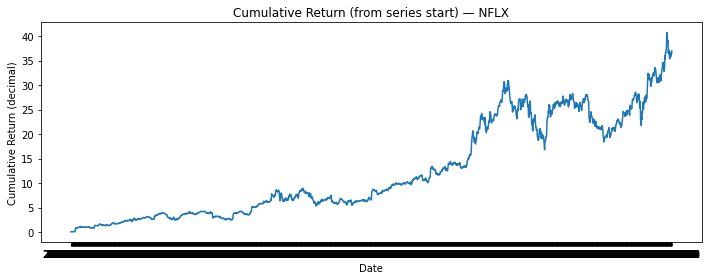

In [45]:
faang = (spark.read.csv("hdfs://namenode:9000/data/updated/*.csv",
                        header=True, inferSchema=True))

faang.createOrReplaceTempView("prices")

# Day Pair with Next Day or Next trade date session
spark.sql("""
CREATE OR REPLACE TEMP VIEW prev_day AS
SELECT
  ticker,
  Date AS prev_date,
  LEAD(Date) OVER (PARTITION BY ticker ORDER BY Date) AS next_date,
  `Adj Close` AS adj_prev
FROM prices
""")

# Daily returns by JOIN (today vs yesterday)
spark.sql("""
CREATE OR REPLACE TEMP VIEW daily_returns AS
SELECT
  p.Date,
  p.ticker,
  p.`Adj Close` AS adj_close,
  d.adj_prev,
  (p.`Adj Close` / d.adj_prev - 1.0) AS daily_return
FROM prices p
JOIN prev_day d
  ON p.ticker = d.ticker
 AND p.Date   = d.next_date
""")

# Compute the Cumulative return from the first row to the current row
# Cumulative return = e ^ (sum(ln(1 + r_daily_return))) - 1.0
spark.sql("""
CREATE OR REPLACE TEMP VIEW cumulative_returns AS
SELECT
  ticker,
  Date,
  EXP(SUM(LOG(1.0 + daily_return)) OVER (
      PARTITION BY ticker ORDER BY Date
      ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
  )) - 1.0 AS cumulative_return
FROM daily_returns
""")

result = spark.sql("""
SELECT ticker, Date, cumulative_return
FROM cumulative_returns
ORDER BY ticker, Date
""")

result.show(10)

# Plot the diagram
df_cum = result.toPandas()
plot_per_ticker(
    df=df_cum,
    x="Date",
    y="cumulative_return",
    title="Cumulative Return (from series start)",
    ylabel="Cumulative Return (decimal)",
    fname_prefix="cumulative_return"
)

# Volume Trend 

+----------+------+---------+-------------------+------------------+
|      Date|ticker|   Volume|            avg_vol|         vol_ratio|
+----------+------+---------+-------------------+------------------+
|2013-01-02|  AAPL|560518000|6.249249333333334E8|0.8969365280565964|
|2013-01-03|  AAPL|352965200|6.249249333333334E8|0.5648121577055548|
|2013-01-04|  AAPL|594333600|6.249249333333334E8| 0.951047987203583|
|2013-01-07|  AAPL|484156400|6.249249333333334E8|0.7747432918343046|
|2013-01-08|  AAPL|458707200|6.249249333333334E8|0.7340196806571114|
|2013-01-09|  AAPL|407604400|6.249249333333334E8|0.6522453790183226|
|2013-01-10|  AAPL|601146000|6.249249333333334E8|0.9619491365042884|
|2013-01-11|  AAPL|350506800|6.249249333333334E8|0.5608782452164388|
|2013-01-14|  AAPL|734207600|6.249249333333334E8|1.1748732701122289|
|2013-01-15|  AAPL|876772400|6.249249333333334E8|1.4030043501758183|
+----------+------+---------+-------------------+------------------+
only showing top 10 rows



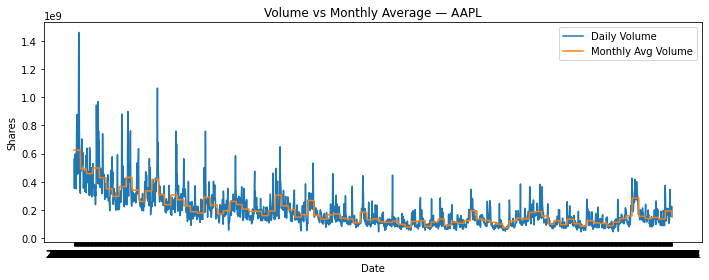

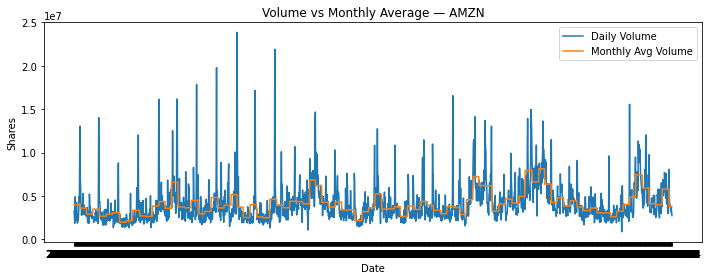

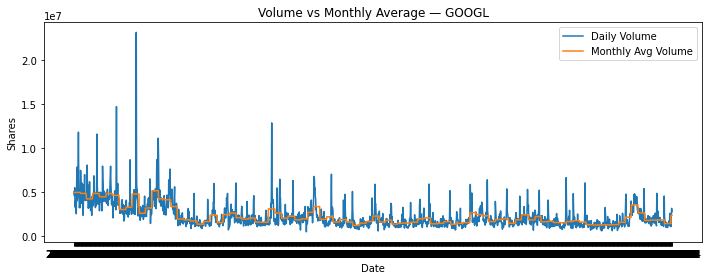

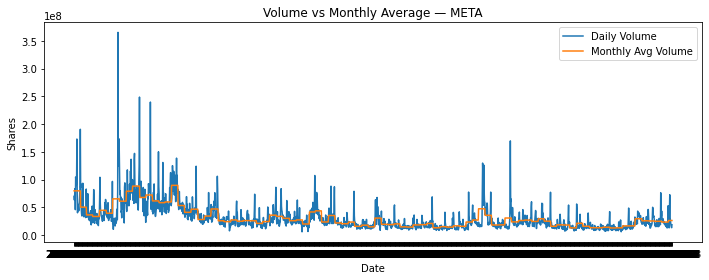

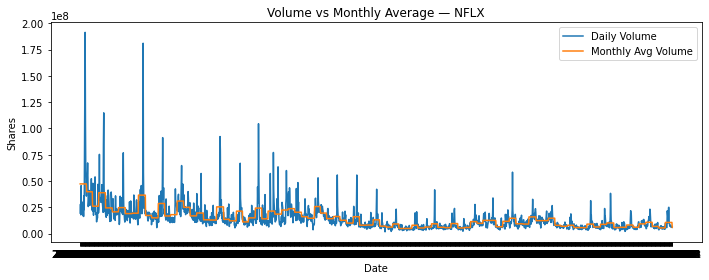

In [48]:
faang = (spark.read.csv("hdfs://namenode:9000/data/updated/*.csv",
                        header=True, inferSchema=True))

faang.createOrReplaceTempView("prices")

# Add label year and month
spark.sql("""
CREATE OR REPLACE TEMP VIEW daily_with_month AS
SELECT
  ticker,
  Date,
  Volume,
  DATE_FORMAT(Date, 'yyyy-MM') AS ym
FROM prices
""")

# Get the monthly average volume of each company
spark.sql("""
CREATE OR REPLACE TEMP VIEW monthly_avg AS
SELECT
  ticker,
  ym,
  AVG(Volume) AS avg_vol
FROM daily_with_month
GROUP BY ticker, ym
""")

# Get the monthly average volume and volume ratio of each company that day
spark.sql("""
CREATE OR REPLACE TEMP VIEW volume_trend AS
SELECT
  d.Date,
  d.ticker,
  d.Volume,
  m.avg_vol,
  CASE WHEN m.avg_vol > 0 THEN d.Volume / m.avg_vol END AS vol_ratio
FROM daily_with_month d
JOIN monthly_avg m
  ON d.ticker = m.ticker
 AND d.ym = m.ym
""")

# Average volume and total volume
result = spark.sql("""
SELECT Date, ticker, Volume, avg_vol, vol_ratio
FROM volume_trend 
ORDER BY ticker, Date
""")

result.show(10)

# Plot the diagram 
df_vol = result.toPandas()
for t in sorted(df_vol['ticker'].unique()):
    d = df_vol[df_vol['ticker'] == t].sort_values("Date")
    plt.figure(figsize=(10,4))
    plt.plot(d["Date"], d["Volume"], label="Daily Volume")
    plt.plot(d["Date"], d["avg_vol"], label="Monthly Avg Volume")
    plt.title(f"Volume vs Monthly Average — {t}")
    plt.xlabel("Date")
    plt.ylabel("Shares")
    plt.legend()
    plt.tight_layout()
    plt.show()
    